In [57]:
import os
import cv2
import math
import datetime
import numpy as np
from PIL import Image
from tqdm import tqdm
from enum import Enum
import functions as f
from patchify import patchify
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Rescaling
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from keras.models import Model, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

In [39]:
def load_images_and_masks(data_dir):
    image_list = []
    mask_list = []

    for root, dirs, files in tqdm(os.walk(data_dir)):
        for file in files:
            if file.endswith(".jpg"): 
                image_path = os.path.join(root, file)
                mask_path = (os.path.join(root, file[:-4]) + "_lab.png").replace("image", "mask") 

                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path)

                image_list.append(np.asarray(image))
                mask_list.append(np.asarray(mask))

    return image_list, mask_list

data_dir = r"D:\Datasets\FloodNet\FloodNet Challenge @ EARTHVISION 2021 - Track 1\Train\Labeled\Flooded"
images, masks = load_images_and_masks(data_dir)

3it [00:17,  5.77s/it]


In [50]:
print("Images: ", len(images))
print("Masks: ", len(masks))

print("Image shape: ", images[0].shape)
print("Mask shape: ", masks[0].shape)

Images:  51
Masks:  51
Image shape:  (3000, 4000, 3)
Mask shape:  (3000, 4000, 3)


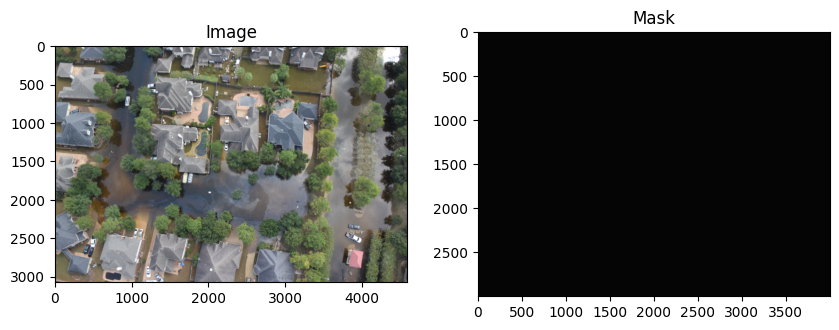

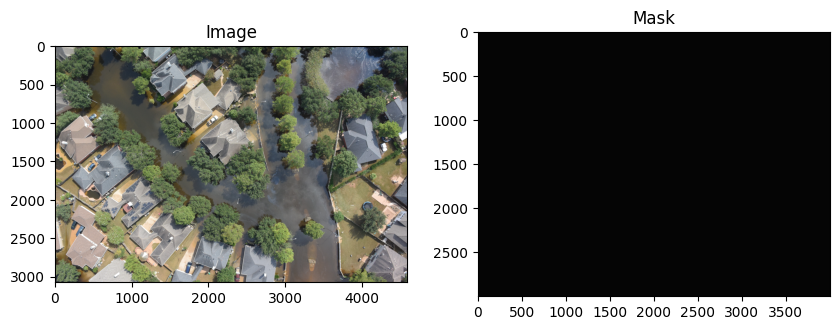

In [48]:
def display_images(images, masks):
    for i in range(2):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')

        plt.subplot(1, 2, 2)
        plt.imshow(masks[i])
        plt.title('Mask')

        plt.show()

display_images(images[20:], masks)

In [51]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 
             'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 'Water': [0, 191, 255], 
             'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

In [52]:
def to_RGB(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

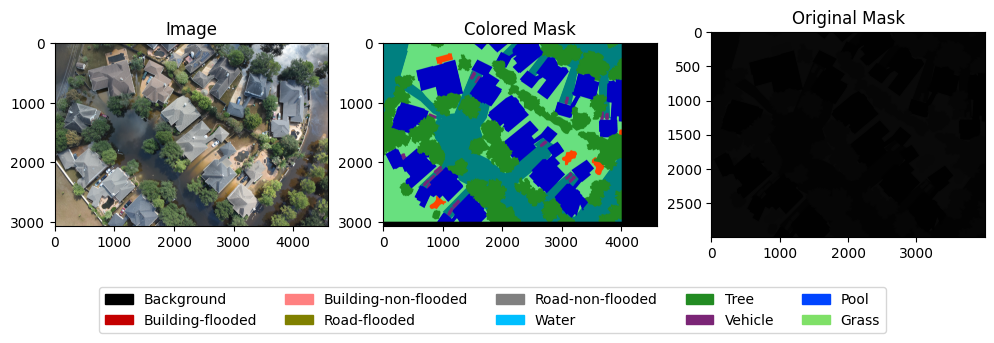

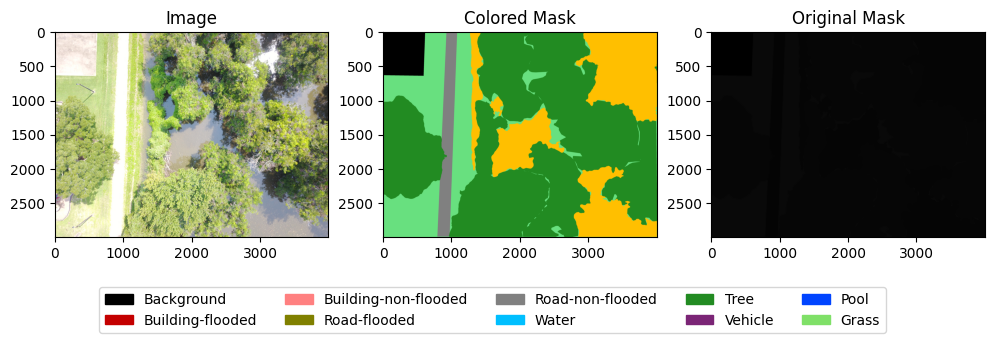

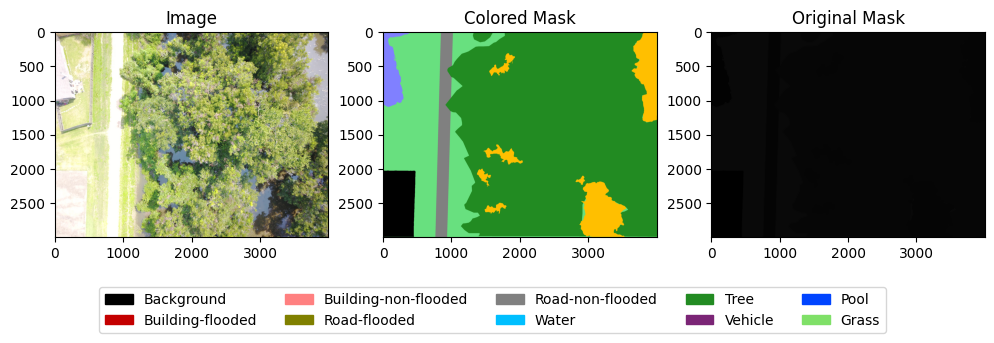

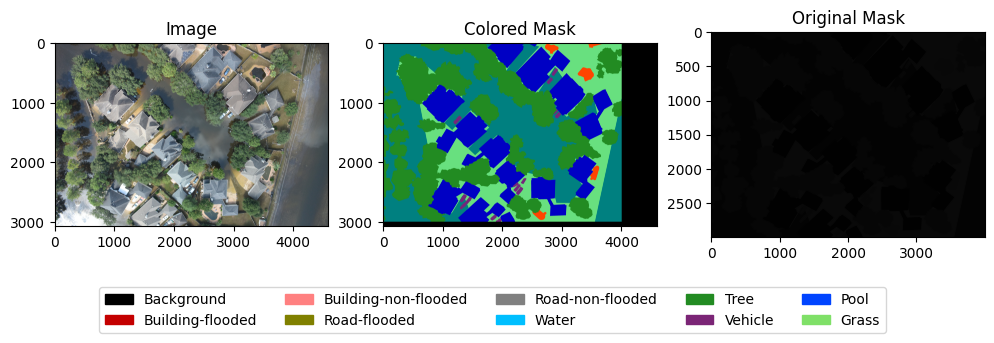

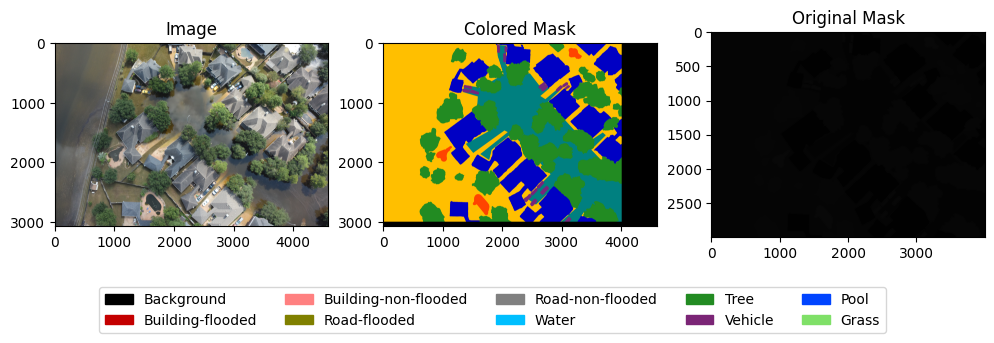

In [58]:
handles = [
    Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()
]
labels = [n for n,c in color_map.items()]

def display_images_with_masks(images, masks, class_map, color_map):
    for i in range(5):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title('Image')

        plt.subplot(1, 3, 2)
        mask_colored = np.zeros_like(images[i], dtype=np.uint8)
        for class_name, class_idx in class_map.items():
            color = color_map[class_name]
            mask_indices = np.where(masks[i] == class_idx)
            mask_colored[mask_indices[0], mask_indices[1], :] = color
        plt.imshow(cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB))
        plt.title('Colored Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(masks[i], cmap='viridis')  # Using viridis colormap for visualization
        plt.title('Original Mask')

        plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
        plt.show()

display_images_with_masks(images[10:], masks[10:], class_map, color_map)

In [ ]:
seed=24
batch_size= 16
n_classes = 10
data_dir = r"E:\Segmentation\datasets\FloodNet"
print(os.path.join(data_dir, 'train'))

In [13]:
scaler = MinMaxScaler()

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = to_categorical(mask, num_class)
    return (img,mask)

def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "D:/post_flood_detection/FloodNet-Supervised_v1.0/patches_data_segmentation/train_images/"
train_mask_path = "D:/post_flood_detection/FloodNet-Supervised_v1.0/patches_data_segmentation/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = "D:/post_flood_detection/FloodNet-Supervised_v1.0/patches_data_segmentation/val_images/"
val_mask_path = "D:/post_flood_detection/FloodNet-Supervised_v1.0/patches_data_segmentation/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

In [ ]:
X_train, Y_train = train_img_gen.__next__()
X_val, Y_val = train_img_gen.__next__()